<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/NEW_XGBOOST(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic XGBoost

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost

from xgboost import XGBClassifier



In [2]:

# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-2647355421.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [3]:

# Ensure the date index is set for easy filtering
df.index = pd.to_datetime(df.index)

# Train = 2014-01-01 to 2023-12-31
train = df.loc["2014-01-01":"2023-12-31"]

# Test = 2024-01-01 to 2024-12-31
test = df.loc["2024-01-01":"2024-12-31"]

# Features & Target
X_train = train[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train['Target']

X_test = test[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test = test['Target']

In [4]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit only on train
X_test_scaled = scaler.transform(X_test)         # transform test (no leakage)


In [6]:
# Define XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,      # number of trees
    learning_rate=0.05,    # step size shrinkage
    max_depth=5,           # depth of each tree
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"  # suppress warnings
)

# Fit model on training set
xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:42:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.5220883534136547

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.70      0.57       115
           1       0.59      0.37      0.46       134

    accuracy                           0.52       249
   macro avg       0.54      0.53      0.52       249
weighted avg       0.54      0.52      0.51       249



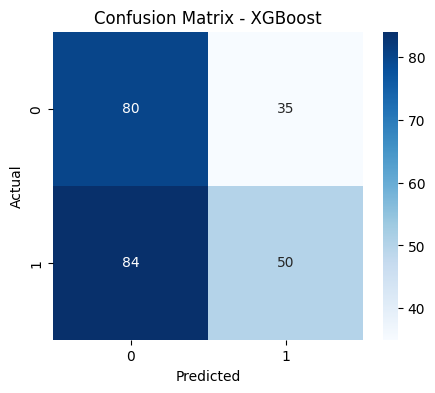

In [7]:
# Predictions
y_pred = xgb_model.predict(X_test_scaled)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


/tmp/ipython-input-488620791.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances, palette="Blues_r")


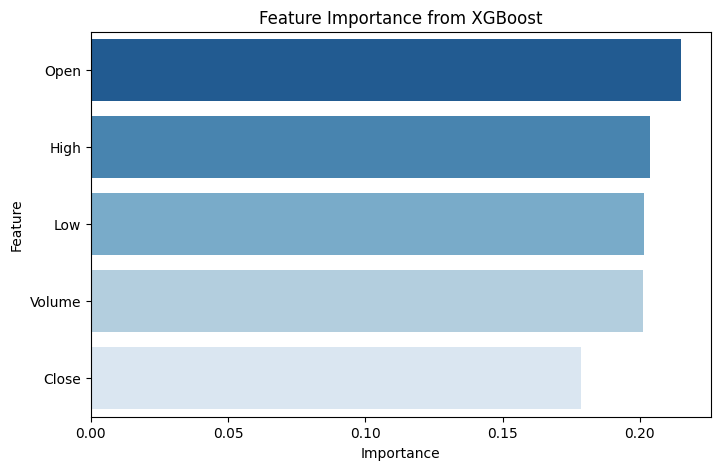

  Feature  Importance
3    Open    0.215066
1    High    0.203823
2     Low    0.201347
4  Volume    0.201153
0   Close    0.178611


In [10]:
# Define feature names manually
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume']

# Create DataFrame for importance
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=importances, palette="Blues_r")
plt.title("Feature Importance from XGBoost")
plt.show()

# Show numeric values as table
print(importances)


# Added features

In [11]:

import pandas as pd
import numpy as np
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-3287618951.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [13]:
# -------------------------------
# Feature Engineering
# -------------------------------
df = df.copy()

# 1. Lagged Returns (1–5 days)
df['Return'] = df['Close'].pct_change()
for lag in range(1, 6):
    df[f'Return_t-{lag}'] = df['Return'].shift(lag)

# 2. Lagged Volume (1–5 days)
for lag in range(1, 6):
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)

# 3. Ratios & Normalisations
df['Close_SMA20'] = df['Close'] / df['Close'].rolling(20).mean()  # only keep ratio
df['High_Low'] = df['High'] / df['Low']
df['Close_Open'] = df['Close'] / df['Open']


# 4. Volatility & Risk
df['RollingStd_20'] = df['Close'].rolling(20).std()
df['ATR_14'] = (df['High'] - df['Low']).rolling(14).mean()
df['SquaredReturn'] = df['Return']**2

# 5. Momentum & ROC
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
df['ROC_5'] = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)


# RSI (14)
delta = df['Close'].diff()

gain = delta.where(delta > 0, 0)   # keep positive diffs
loss = -delta.where(delta < 0, 0)  # keep negative diffs

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))



# MACD (12,26) and Signal (9)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger %B (20, 2 std)
sma20 = df['Close'].rolling(20).mean()
std20 = df['Close'].rolling(20).std()
upper = sma20 + 2 * std20
lower = sma20 - 2 * std20
df['Bollinger_%B'] = (df['Close'] - lower) / (upper - lower)

# 7. Volume Indicators
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df['MFI'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['VPT'] = (df['Volume'] * (df['Close'].pct_change())).cumsum()

# 8. Z-Scores
for win in [5, 10, 20]:
    rolling_mean = df['Close'].rolling(win).mean()
    rolling_std = df['Close'].rolling(win).std()
    df[f'ZScore_{win}'] = (df['Close'] - rolling_mean) / rolling_std

# 9. Sharpe-like ratio
df['SharpeLike_20'] = df['Return'].rolling(20).mean() / df['Return'].rolling(20).std()

# -------------------------------
# Finalise Dataset
# -------------------------------
df.dropna(inplace=True)

# Define Features (same for KNN, SVM, RF, XGBoost)
features = [
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Close_SMA20','High_Low','Close_Open',
    'RollingStd_20','ATR_14','SquaredReturn',
    'Momentum_5','Momentum_10','ROC_5','ROC_10',
    'RSI_14','MACD','MACD_Signal','Bollinger_%B',
    'OBV','MFI','VPT',
    'ZScore_5','ZScore_10','ZScore_20',
    'SharpeLike_20'
]

X = df[features]
y = df['Target']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature matrix shape: (2977, 31)
Target distribution:
 Target
0    1525
1    1452
Name: count, dtype: int64


In [14]:
# Split dataset into train (2014–2023) and test (2024)
train = df.loc["2014-01-01":"2023-12-31"]
test = df.loc["2024-01-01":"2024-12-31"]

X_train = train[features]
y_train = train["Target"]

X_test = test[features]
y_test = test["Target"]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (2497, 31) Test size: (249, 31)


In [15]:


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Define XGBoost model
xgb_model = XGBClassifier(
    n_estimators=500,      # number of boosting rounds (trees)
    learning_rate=0.05,    # step size shrinkage
    max_depth=6,           # max depth of each tree
    subsample=0.8,         # sample ratio of training instances
    colsample_bytree=0.8,  # subsample ratio of features
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit model on training set
xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.4738955823293173

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.77      0.58       115
           1       0.53      0.22      0.31       134

    accuracy                           0.47       249
   macro avg       0.49      0.50      0.44       249
weighted avg       0.50      0.47      0.43       249



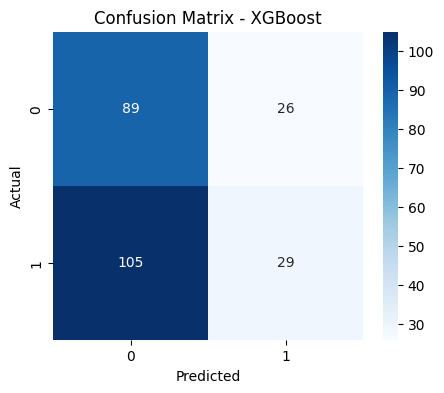

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions
y_pred = xgb_model.predict(X_test_scaled)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


/tmp/ipython-input-4079531690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances, palette="Blues_r")


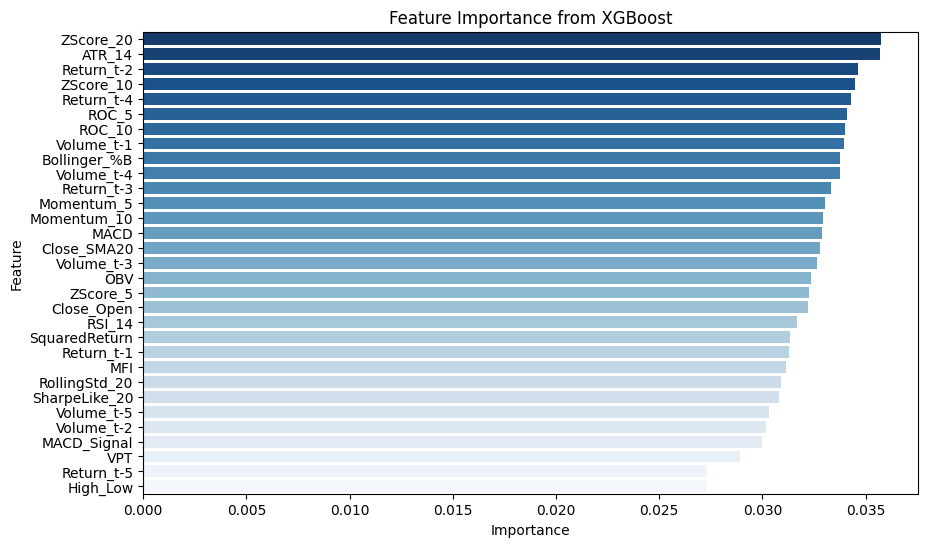

          Feature  Importance
29      ZScore_20    0.035754
14         ATR_14    0.035717
1      Return_t-2    0.034636
28      ZScore_10    0.034504
3      Return_t-4    0.034274
18          ROC_5    0.034110
19         ROC_10    0.034013
5      Volume_t-1    0.033950
23   Bollinger_%B    0.033755
8      Volume_t-4    0.033754
2      Return_t-3    0.033334
16     Momentum_5    0.033052
17    Momentum_10    0.032915
21           MACD    0.032879
10    Close_SMA20    0.032776
7      Volume_t-3    0.032657
24            OBV    0.032339
27       ZScore_5    0.032261
12     Close_Open    0.032203
20         RSI_14    0.031675
15  SquaredReturn    0.031342
0      Return_t-1    0.031297
25            MFI    0.031128
13  RollingStd_20    0.030903
30  SharpeLike_20    0.030811
9      Volume_t-5    0.030332
6      Volume_t-2    0.030172
22    MACD_Signal    0.029997
26            VPT    0.028901
4      Return_t-5    0.027313
11       High_Low    0.027244


In [18]:
# Create DataFrame for importance
importances = pd.DataFrame({
    'Feature': features,   # use your feature list (31 features)
    'Importance': xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importances, palette="Blues_r")
plt.title("Feature Importance from XGBoost")
plt.show()

# Print table
print(importances)
